In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import shutil
import numpy as np

In [11]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['font.size'] = 18


In [35]:
from datasets import EmbeddedDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import math
from algorithms import segments

class TrainSequence(tf.keras.utils.Sequence):
    def __init__(self,Xs_array,Ys_array, batch_size=100):
        self.batch_size = batch_size
        self.Xs_array = Xs_array
        self.Ys_array = Ys_array
        self.lengths = [y.shape[0] for y in tqdm(Ys_array)]

    def setBatchSize(self,size):
        self.batch_size = size
            
    def __len__(self):
        return math.ceil(len(self.Ys_array)/self.batch_size)

    def __getitem__(self,index):
        batch_x = self.Xs_array[index * self.batch_size : (index+1)*self.batch_size]
        batch_y = self.Ys_array[index * self.batch_size : (index+1)*self.batch_size]
        max_len = max(self.lengths[index * self.batch_size : (index+1)*self.batch_size])

        batch_x = np.array([np.pad(x,((0,max_len - x.shape[0]),(0,0))) for x in batch_x])
        batch_y = np.array([np.pad(y,(0,max_len - y.shape[0])) for y in batch_y])
        return batch_x, batch_y
    
with EmbeddedDataset('../data/wiki_segments_test.npz') as ds:
    mask = np.array([True if x < 1000 else False for x in tqdm(range(len(ds.get_embeddings())))])
    mask2 = np.array([True if x < 1500 and x > 1000 else False for x in tqdm(range(len(ds.get_embeddings())))])
    Xs_train = ds[ds.get_embeddings()[mask]]
    Ys_train = [segments.tags_to_array(s) for s in ds[ds.get_segments()[mask]]]
    train_set = TrainSequence(Xs_train, Ys_train,batch_size=10)

    Xs_test = ds[ds.get_embeddings()[mask2]]
    Ys_test = [segments.tags_to_array(s) for s in ds[ds.get_segments()[mask2]]]
    test_set = TrainSequence(Xs_test, Ys_test,batch_size=10)


100%|██████████| 499/499 [00:00<00:00, 517162.76it/s]


In [1]:
from algorithms import segments
from datasets import EmbeddedDataset, windowed
from models import cnn_boundary_classifier as cnn_model

model = cnn_model.make_attention_cnn(cnn_dropout=0.1,dense_dropout=0)
with EmbeddedDataset('wiki_segments_trans_300.npz') as ds:
    model = cnn_model.train(model,ds,epochs=100,batch_size=8)





Epoch 1/100
12/12 [==============================] - 6s 282ms/step - loss: 3.3100 - accuracy: 0.4709 - val_loss: 1.3111 - val_accuracy: 0.0961
Epoch 2/100
12/12 [==============================] - 3s 227ms/step - loss: 1.2325 - accuracy: 0.4900 - val_loss: 1.2260 - val_accuracy: 0.9039
Epoch 3/100
12/12 [==============================] - 3s 235ms/step - loss: 1.2399 - accuracy: 0.3572 - val_loss: 1.2308 - val_accuracy: 0.0961
Epoch 4/100
12/12 [==============================] - 3s 230ms/step - loss: 1.2418 - accuracy: 0.1120 - val_loss: 1.2305 - val_accuracy: 0.0961
Epoch 5/100
12/12 [==============================] - 3s 250ms/step - loss: 1.2303 - accuracy: 0.5716 - val_loss: 1.2364 - val_accuracy: 0.0961
Epoch 6/100
12/12 [==============================] - 3s 241ms/step - loss: 1.2399 - accuracy: 0.4851 - val_loss: 1.2284 - val_accuracy: 0.0961
Epoch 7/100
12/12 [==============================] - 3s 253ms/step - loss: 1.2395 - accuracy: 0.1265 - val_loss: 1.2264 - val_accuracy: 0.1170

INFO:tensorflow:Assets written to: cnn_model\assets


INFO:tensorflow:Assets written to: cnn_model\assets


Evaluating:[..........][127/127] => DONE [0h 2min 35s][eta: 0h 0min 0s]   h 2min 35s][eta: 0h 0min 0s]    


AttributeError: 'Rectangle' object has no property 'labels'

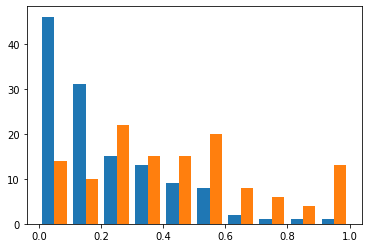

In [8]:
from algorithms import boundary_classifier, segments
from models import cnn_boundary_classifier as cnn_model
from datasets import EmbeddedDataset
import matplotlib.pyplot as plt
import evaluation

model = cnn_model.load("cnn_model")

bcnn = boundary_classifier.with_params(classifier = model)
with EmbeddedDataset('wiki_segments_trans_300.npz') as ds:
    p,w = evaluation.evaluate_segmenter(ds,bcnn,4)
    plt.hist([p,w], label=["Pk", "WD"])
    



In [64]:
from math import floor
import tensorflow as tf
class Wiki727Sequence(tf.keras.utils.Sequence):

    def __init__(self, emb_dataset, batch_size):
        self.emb_ds = emb_dataset
        self.emb_ds.open()
        self.batch_size = batch_size
        self.segs_keys = self.emb_ds.get_segments()
        self.embs_keys = self.emb_ds.get_segments()
        self.len = len(self.segs_keys)
        self.emb_ds.close()

    def __len__(self):
        return floor(self.len/self.batch_size)

    def __getitem__(self, idx):
        self.emb_ds.open()
        Es = self.emb_ds.get_embeddings()[idx*self.batch_size : (idx + 1)*self.batch_size]
        
        batch_x = [np.inner(e,e) for e in self.emb_ds[Es]]

        batch_y = tf.ragged.constant([[make_segmat(self.emb_ds[ds.segmentation(e)],self.emb_ds[e]) for e in Es]])
        self.emb_ds.close()
        print(batch_x.shape)

        return batch_x,batch_y

In [82]:
autoencoder.save('models/autoencoder-100e-10k')

INFO:tensorflow:Assets written to: models/autoencoder-100e-10k\assets


INFO:tensorflow:Assets written to: models/autoencoder-100e-10k\assets


(177, 512)
[[ 0.01121824 -0.04884298 -0.01816592 ... -0.02734746 -0.03538588
  -0.05324334]
 [ 0.01985284 -0.02306883 -0.03288566 ... -0.02726456 -0.01232668
  -0.03433123]
 [ 0.03415528  0.01724535 -0.00035553 ... -0.04857348 -0.01594695
  -0.02155956]
 ...
 [-0.01567085 -0.0143671   0.07096677 ... -0.03202876 -0.07014536
  -0.07721077]
 [ 0.01807482 -0.02165476  0.05633271 ... -0.02410685 -0.03605366
  -0.06767423]
 [-0.00174053 -0.0059826   0.02334284 ...  0.02340716 -0.01111449
  -0.1164907 ]]
[0.46288258 0.4660153  0.3814867  0.31621855 0.4207476  0.3980555
 0.30864385 0.46474594 0.65603185 0.6495762  0.54490817 0.5396081
 0.5625347  0.3306581  0.48789728 0.6015561  0.4242937  0.4895287
 0.65213853 0.65997976 0.60955477 0.5243608  0.60859203 0.7311591
 0.7240666  0.5069784  0.61301607 0.5574012  0.56712085 0.67422867
 0.6732623  0.6714144  0.4611529  0.45930514 0.45771354 0.620877
 0.4467579  0.29320306 0.43287265 0.529982   0.5420959  0.4297741
 0.33804435 0.54431224 0.4937436  0

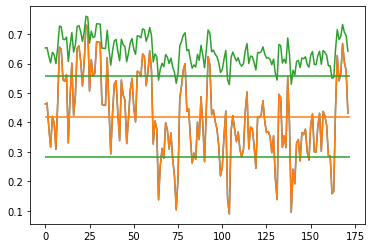

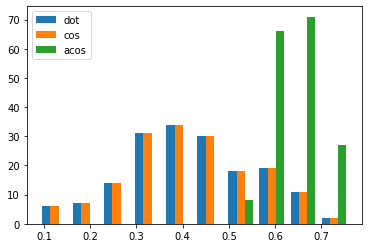

In [44]:
from algorithms import block_comparison

with EmbeddedDataset('wiki_segments_trans_300.npz') as ds:
    seg, emb = ds.get_file('wiki_727/train/12/94/82/1294820')
v = np.lib.stride_tricks.sliding_window_view(emb,3,0)
print(emb.shape)
v = block_comparison.encode_blocks(v,'v-mean')
print(v)
score = np.array([block_comparison.similarity_measure(v[i],v[i+3],'dot') for i in range(len(v)-3)])
score1 = np.array([block_comparison.similarity_measure(v[i],v[i+3],'cos') for i in range(len(v)-3)])
score2 = np.array([block_comparison.similarity_measure(v[i],v[i+3],'acos') for i in range(len(v)-3)])/np.pi
print(score)
plt.plot(score)
plt.plot(score1)
plt.plot(score2)
mean_cross = np.mean(score)
std_cross = np.std(score)
plt.hlines([mean_cross, mean_cross + std_cross, mean_cross-std_cross],0,len(score),colors=['C1','C2','C2'])
tau = np.mean(np.mean(score))-np.std(np.mean(score))
np.mean(score,0) > tau
plt.figure()
plt.hist([score,score1,score2],label= ['dot', 'cos','acos'])
plt.legend()

In [19]:
### block comparison of embedding
from algorithms import simple
import numpy as np
from scipy.cluster.vq import whiten

d = np.vstack([np.ones(10)*i] for i in range(5))
d = whiten(d)
print(d, d.shape)

v = np.lib.stride_tricks.sliding_window_view(d,3,0)
print(v, v.shape)

v = np.array([u/np.sqrt(u.dot(u.T)) for u in np.sum(v,2)])
print(v, v.shape)



[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.70710678 0.70710678 0.70710678 0.70710678 0.70710678 0.70710678
  0.70710678 0.70710678 0.70710678 0.70710678]
 [1.41421356 1.41421356 1.41421356 1.41421356 1.41421356 1.41421356
  1.41421356 1.41421356 1.41421356 1.41421356]
 [2.12132034 2.12132034 2.12132034 2.12132034 2.12132034 2.12132034
  2.12132034 2.12132034 2.12132034 2.12132034]
 [2.82842712 2.82842712 2.82842712 2.82842712 2.82842712 2.82842712
  2.82842712 2.82842712 2.82842712 2.82842712]] (5, 10)
[[[0.         0.70710678 1.41421356]
  [0.         0.70710678 1.41421356]
  [0.         0.70710678 1.41421356]
  [0.         0.70710678 1.41421356]
  [0.         0.70710678 1.41421356]
  [0.         0.70710678 1.41421356]
  [0.         0.70710678 1.41421356]
  [0.         0.70710678 1.41421356]
  [0.         0.70710678 1.41421356]
  [0.         0.70710678 1.41421356]]

 [[0.70710678 1.41421356 2.12132034]
  [0.70710678 1

C:\Users\Radoslaw\AppData\Local\Temp/ipykernel_18280/1870392530.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  d = np.vstack([np.ones(10)*i] for i in range(5))


Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 

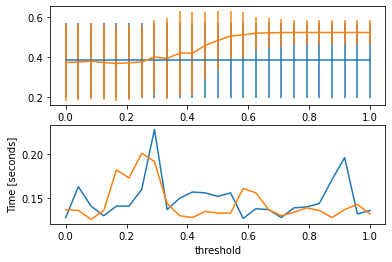

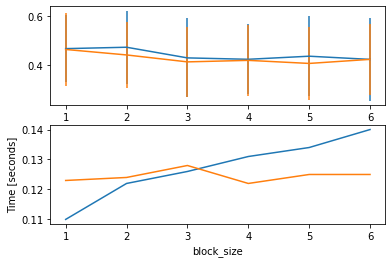

In [1]:
from evaluation import evaluate_segmenter
from algorithms import simple, graphseg, block_comparison
from datasets import EmbeddedDataset
import matplotlib.pyplot as plt
import numpy as np
import time


def evaluate_range(dataset,segmenter_factory,argname, values, window_range = 4,**kwargs):
    Ms, Ss = [], []
    Ts = []
    for x in values:
        seg = segmenter_factory(**{argname:x,**kwargs})
        start = time.time()
        p,w = evaluate_segmenter(dataset,seg,window_range)
        end = time.time()
        Ms.append(np.mean(p))
        Ss.append(np.std(w))
        Ts.append(end - start)
    plt.subplot(2,1,1)
    plt.errorbar(values,Ms,Ss)
    plt.subplot(2,1,2)
    plt.plot(values,Ts)
    plt.xlabel(argname)
    plt.ylabel("Time [seconds]")    

with EmbeddedDataset('wiki_segments.npz') as ds:
    evaluate_range(ds,block_comparison.with_params,"threshold",np.linspace(0.0,1,num=25),mode = 'max')
    evaluate_range(ds,block_comparison.with_params,"threshold",np.linspace(0.0,1,num=25),mode = 'mean')
    plt.figure()
    evaluate_range(ds,block_comparison.with_params,"block_size",[1,2,3,4,5,6],mode = 'max')
    evaluate_range(ds,block_comparison.with_params,"block_size",[1,2,3,4,5,6],mode = 'mean')


Evaluating:[..........][50/50] => DONE [0h 0min 5s][eta: 0h 0min 0s]   0min 0s]     
Evaluating:[..........][50/50] => DONE [0h 1min 11s][eta: 0h 0min 0s]   0min 0s]     
Evaluating:[..........][50/50] => DONE [0h 0min 1s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 1min 39s][eta: 0h 0min 0s]   0min 0s]     
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 2min 25s][eta: 0h 0min 0s]   0min 0s]     
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 2min 59s][eta: 0h 0min 0s]   0min 0s]     
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 2min 46s][eta: 0h 0min 0s]   0min 0s]     
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 3min 57s][eta: 0h 0min

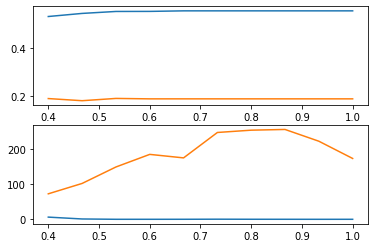

In [4]:
from evaluation import evaluate_segmenter
from algorithms import simple, graphseg
from datasets import EmbeddedDataset
import matplotlib.pyplot as plt
import numpy as np
import time
Ms, Ms2 = [], []
Ts,Ts2 = [], []
l = np.linspace(0.4,1,num=10)
for n in l:
    gs = graphseg.with_params(threshold = n,n_min_seg = 3,clique_finder='precise')
    gs2 = graphseg.with_params(threshold = n,n_min_seg = 3,clique_finder='clique_removal')
    with EmbeddedDataset('wiki_segments.npz') as ds:
        start = time.time()
        p1,w1 = evaluate_segmenter(ds,gs,4)
        end = time.time()
        Ts.append(end - start)
        start = time.time()
        p2,w2 = evaluate_segmenter(ds,gs2,4)
        end = time.time()
        Ts2.append(end - start)
    Ms.append(np.mean(w1))
    Ms2.append(np.std(w2))
    
plt.subplot(211)
plt.plot(l,Ms)
plt.plot(l,Ms2)
plt.subplot(212)
plt.plot(l,Ts)
plt.plot(l,Ts2)


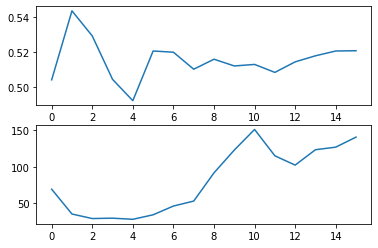

In [4]:
plt.subplot(211)
plt.plot(Ms)
plt.subplot(212)
plt.plot(Ts)

Evaluating segmenter...
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Pmean: 0.4299190613661345 Pstv: 0.16259918746584023
Wmean: 0.5240880388000552 Wstv: 0.14721276019145885
Evaluating segmenter done in 0.43 s


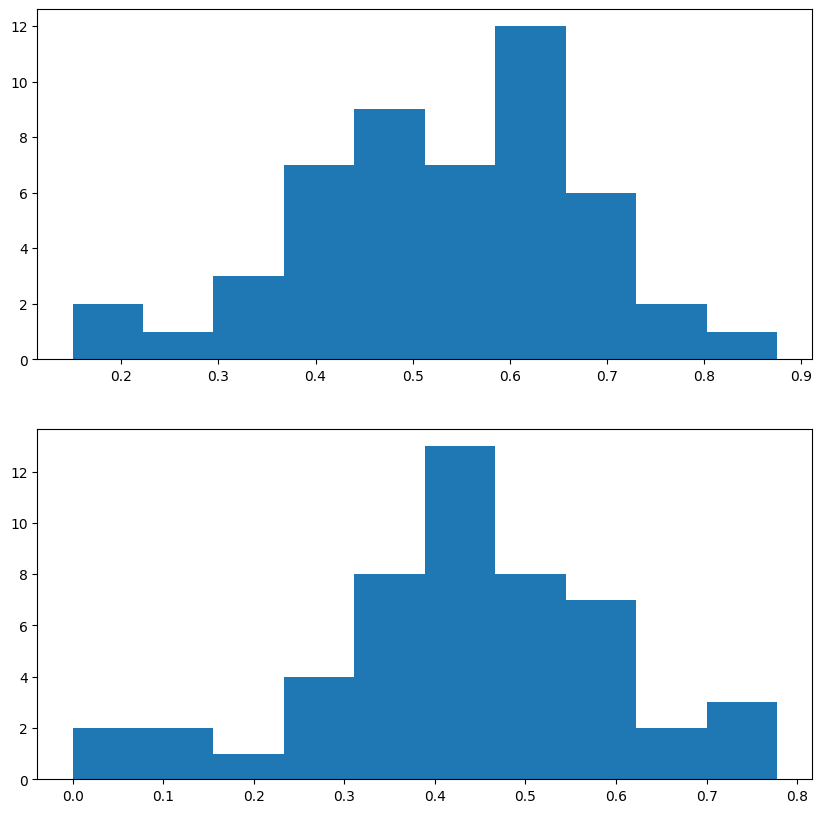

In [10]:
from evaluation import evaluate_segmenter
from algorithms import simple, graphseg
from datasets import EmbeddedDataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
with EmbeddedDataset('wiki_segments.npz') as ds:
    p,w = evaluate_segmenter(ds,lol,4)
    plt.subplot(2,1,1)
    plt.hist(w)
    plt.subplot(2,1,2)
    plt.hist(p)
 


Evaluating:[..........][300/300] => DONE [0h 0min 1s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][300/300] => DONE [0h 0min 1s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][300/300] => DONE [0h 0min 1s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][127/127] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0h 0min 0s][eta: 0h 0min 0s]   
Evaluating:[..........][127/127] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0h 0min 0s][eta: 0h 0min 0s]   
Evaluating:[..........][127/127] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0h 0min 0s][eta: 0h 0min 0s]   
0.47265466716185356 0.45548822176280773 0.6348535344237227


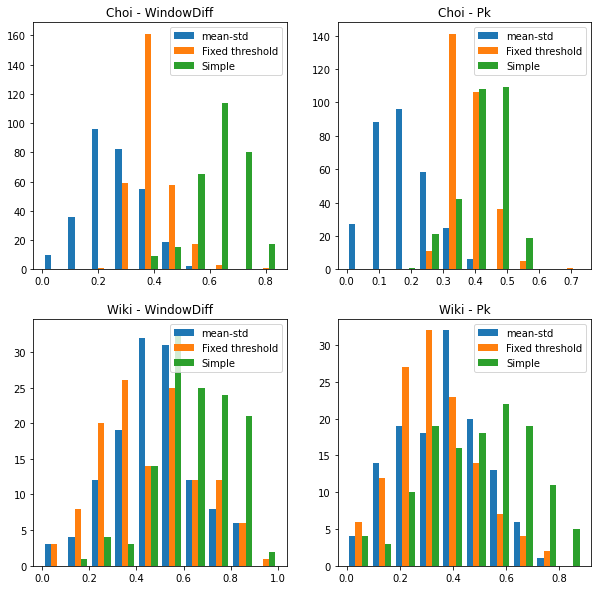

In [3]:
from evaluation import evaluate_segmenter
from algorithms import simple, graphseg, block_comparison
from datasets import EmbeddedDataset
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
gs = block_comparison.with_params(cmp_mode='acos', block_size=3, block_mode='max')
bs = block_comparison.with_params(cmp_mode='cos', block_size=5,threshold=0.6)



with EmbeddedDataset('choi_segments.npz') as ds:
    p1,w1 = evaluate_segmenter(ds,gs,4)
    p2,w2 = evaluate_segmenter(ds,bs,4)
    p3,w3 = evaluate_segmenter(ds,simple.simple_seg,4)

    ax = plt.subplot(2,2,1)
    ax.title.set_text("Choi - WindowDiff")
    plt.hist([w1,w2,w3], label = ["mean-std", "Fixed threshold", "Simple"])
    plt.legend()

    ax = plt.subplot(2,2,2)
    ax.title.set_text("Choi - Pk")
    plt.hist([p1,p2,p3], label = ["mean-std", "Fixed threshold", "Simple"])
    plt.legend()

with EmbeddedDataset('wiki_segments_trans_300.npz') as ds:
    p1,w1 = evaluate_segmenter(ds,gs,4)
    p2,w2 = evaluate_segmenter(ds,bs,4)
    p3,w3 = evaluate_segmenter(ds,simple.simple_seg,4)
    ax = plt.subplot(2,2,3)
    ax.title.set_text("Wiki - WindowDiff")
    plt.hist([w1,w2,w3], label = ["mean-std", "Fixed threshold", "Simple"])
    plt.legend()

    ax = plt.subplot(2,2,4)
    ax.title.set_text("Wiki - Pk")
    plt.hist([p1,p2,p3], label = ["mean-std", "Fixed threshold", "Simple"])
    plt.legend()
    print(np.mean(w1),np.mean(w2),np.mean(w3))




In [1]:
from sklearn.model_selection import ParameterGrid
import numpy as np
from datasets import EmbeddedDataset
from algorithms import block_comparison
from evaluation import evaluate_segmenter
import matplotlib.pyplot as plt
import joblib
import pandas as pd

block_grid = ParameterGrid({'block_size':np.arange(1,5),'std_cutoff':[0.25,0.5,1.0,1.25,1.5,2.0,2.5,3.0] , 'whiten':[False], 'cmp_mode':['dot','cos','acos'], 'block_mode':['max','mean','sum','v-mean'], 'substract_mean':[False], 'check_minimum':[True]})
#block_grid = ParameterGrid({'block_size':[2,3,4],'std_cutoff':[0.25,0.5,1.0,1.25,1.5,2.0,2.5,3.0] ,'check_minimum':[True],'whiten':[False], 'cmp_mode':['acos'], 'block_mode':['max'], 'substract_mean':[False]})
Ms, Sts = [], []
Ps = []
Results = []
def fast_stat(arr):
    m = np.mean(arr)
    c = arr - m
    return m,np.dot(c,c)/a.size

def ev_seg_params(params,ds):
    bs = block_comparison.with_params(**p)
    w,_ = evaluate_segmenter(ds,bs,4,silent = True)
    return fast_stat(w)



# with EmbeddedDataset('wiki_segments_trans_300.npz') as ds:
#     for p in block_grid:
#         bs = block_comparison.with_params(**p)
#         w,pk,d = evaluate_segmenter(ds,bs,ds.mean_segment_length()//2,silent = True,seg_diff=True)
#         Ms.append(np.mean(w))
#         Sts.append(np.std(w))
#         Results.append(p | { "windowdiff_mean":Ms[-1], "windowdiff_std":Sts[-1], "pk_mean":np.mean(pk),"pk_std":np.std(pk), "mean_seg_bias":np.mean(d), "std_seg_bias":np.std(d)})
#         print(f'params:{p}, mean:{Ms[-1]}, std:{Sts[-1]}')

# df = pd.DataFrame(Results)
# df.to_csv("gridsearch-wiki-3001.csv")
# Ms, Sts = [], []
# Ps = []
# Results = []
# with EmbeddedDataset('choi_segments.npz') as ds:
#     for p in block_grid:
#         bs = block_comparison.with_params(**p)
#         w,pk,d = evaluate_segmenter(ds,bs,ds.mean_segment_length()//2,silent = True,seg_diff=True)
#         Ms.append(np.mean(w))
#         Sts.append(np.std(w))
#         Results.append(p | { "windowdiff_mean":Ms[-1], "windowdiff_std":Sts[-1], "pk_mean":np.mean(pk),"pk_std":np.std(pk), "mean_seg_bias":np.mean(d), "std_seg_bias":np.std(d)})
#         print(f'params:{p}, mean:{Ms[-1]}, std:{Sts[-1]}')

# df = pd.DataFrame(Results)
# df.to_csv("gridsearch-choi1.csv")
Ms, Sts = [], []
Ps = []
Results = []  
with EmbeddedDataset('pl_cnn.npz') as ds:
    for p in block_grid:
        bs = block_comparison.with_params(**p)
        w,pk,d = evaluate_segmenter(ds,bs,ds.mean_segment_length()//2,silent = True,seg_diff=True)
        Ms.append(np.mean(w))
        Sts.append(np.std(w))
        Results.append(p | { "windowdiff_mean":Ms[-1], "windowdiff_std":Sts[-1], "pk_mean":np.mean(pk),"pk_std":np.std(pk), "mean_seg_bias":np.mean(d), "std_seg_bias":np.std(d)})
        print(f'params:{p}, mean:{Ms[-1]}, std:{Sts[-1]}')
        


df = pd.DataFrame(Results)
df.to_csv("gridsearch-plcnn1.csv")
df




params:{'block_mode': 'max', 'block_size': 1, 'check_minimum': True, 'cmp_mode': 'dot', 'std_cutoff': 0.25, 'substract_mean': False, 'whiten': False}, mean:0.5369066210441096, std:0.16826573899432198
params:{'block_mode': 'max', 'block_size': 1, 'check_minimum': True, 'cmp_mode': 'dot', 'std_cutoff': 0.5, 'substract_mean': False, 'whiten': False}, mean:0.5343747112542343, std:0.16416586063291816
params:{'block_mode': 'max', 'block_size': 1, 'check_minimum': True, 'cmp_mode': 'dot', 'std_cutoff': 1.0, 'substract_mean': False, 'whiten': False}, mean:0.528619266855658, std:0.14218400060053213
params:{'block_mode': 'max', 'block_size': 1, 'check_minimum': True, 'cmp_mode': 'dot', 'std_cutoff': 1.25, 'substract_mean': False, 'whiten': False}, mean:0.5113403367923998, std:0.1315662844983723
params:{'block_mode': 'max', 'block_size': 1, 'check_minimum': True, 'cmp_mode': 'dot', 'std_cutoff': 1.5, 'substract_mean': False, 'whiten': False}, mean:0.49582826354795523, std:0.12281781758299576
para

,block_mode,block_size,check_minimum,cmp_mode,std_cutoff,substract_mean,whiten,windowdiff_mean,windowdiff_std,pk_mean,pk_std,mean_seg_bias,std_seg_bias
0,max,1,True,dot,0.25,False,False,0.536907,0.168266,0.983441,0.029529,27.48,7.725904
1,max,1,True,dot,0.50,False,False,0.534375,0.164166,0.959418,0.045496,23.33,6.890653
2,max,1,True,dot,1.00,False,False,0.528619,0.142184,0.821071,0.085663,12.79,4.508425
3,max,1,True,dot,1.25,False,False,0.511340,0.131566,0.683909,0.115327,7.16,3.474824
4,max,1,True,dot,1.50,False,False,0.495828,0.122818,0.551616,0.112210,2.12,2.281578
...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,v-mean,4,True,acos,1.25,False,False,0.470737,0.138825,0.609520,0.125894,4.67,2.653507
380,v-mean,4,True,acos,1.50,False,False,0.461462,0.138431,0.545981,0.134856,2.00,2.149419
381,v-mean,4,True,acos,2.00,False,False,0.466167,0.157464,0.507963,0.154688,-0.82,1.693399
382,v-mean,4,True,acos,2.50,False,False,0.463676,0.149538,0.523007,0.151622,-0.11,1.782667


wiki segs: 8.01742744983524 (6.234283005029803)
choi segs: 7.032333333333333 (0.8267131035344459)
pl segs: 31.61497619047619 (21.299488762648775)


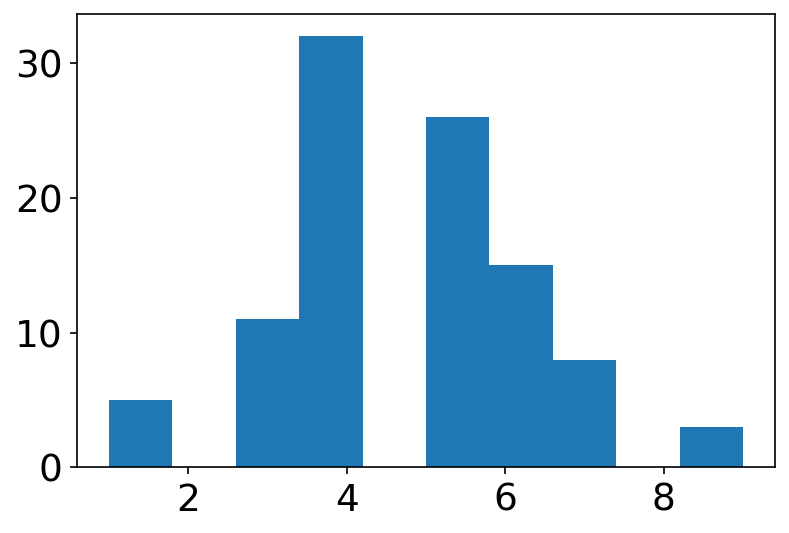

In [18]:
from datasets import EmbeddedDataset
import numpy as np
with EmbeddedDataset('wiki_segments_trans_300.npz') as ds:
   print(f"wiki segs: {np.mean(ds.document_lengths()/ds.segment_lengths())} ({np.std(ds.document_lengths()/ds.segment_lengths())})")


with EmbeddedDataset('choi_segments.npz') as ds:
    print(f"choi segs: {np.mean(ds.document_lengths()/ds.segment_lengths())} ({np.std(ds.document_lengths()/ds.segment_lengths())})")

with EmbeddedDataset('pl_cnn.npz') as ds:
    print(f"pl segs: {np.mean(ds.document_lengths()/ds.segment_lengths())} ({np.std(ds.document_lengths()/ds.segment_lengths())})")
    plt.hist(ds.segment_lengths())

In [4]:
import evaluation
from algorithms import block_comparison, segments
from datasets import EmbeddedDataset
import numpy as np

plbest = block_comparison.with_params(block_mode = 'mean', cmp_mode='dot', block_size=4,std_cutoff=1.5)
Ws,Ds = [], []
with EmbeddedDataset('pl_cnn.npz') as ds:
    for emb in ds.get_embeddings():
        seg =  ds.segmentation(emb)
        inferred = plbest(ds[emb])
        seg_true = segments.tags_to_array(ds[seg])
        p, w = evaluation.evaluate_document(seg_true,inferred,ds.mean_segment_length()//2)
        Ws.append(w)
        Ds.append(evaluation.get_n_seg_diff(seg_true,inferred))
    i = np.argmin(Ws)
    print(ds.get_embeddings()[i])
    print(Ws[i])

23_Wydobywanie_struktury/200112_oczy_przeslonie.txt_emb
0.10655737704918032


In [17]:
from datasets import small_pl
import evaluation
from algorithms import block_comparison, segments, graphseg
from datasets import EmbeddedDataset
import numpy as np
gs = graphseg.with_params(threshold = 0.2, n_min_seg=10)
with EmbeddedDataset('pl_cnn.npz') as ds:
    emb = '23_Wydobywanie_struktury/200108_na_marsa_przez_.txt_emb'
    seg =  ds.segmentation(emb)
    inferred = gs(ds[emb])
    seg_true = segments.tags_to_array(ds[seg])
    p, w = evaluation.evaluate_document(seg_true,inferred,ds.mean_segment_length()//2)
    print(w)



0.23529411764705882


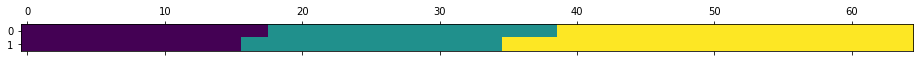

In [18]:
import matplotlib.pyplot as plt
plt.matshow([segments.array_to_tags(seg_true),segments.array_to_tags(inferred)])

In [4]:
from datasets import EmbeddedDataset
import numpy as np
with EmbeddedDataset('wiki_segments_trans_300.npz') as ds:
   print(f"wiki segs: {np.mean(ds.segment_lengths())} ({np.std(ds.segment_lengths())})")


with EmbeddedDataset('choi_segments.npz') as ds:
    print(f"choi segs: {np.mean(ds.segment_lengths())} ({np.std(ds.segment_lengths())})")

with EmbeddedDataset('pl_cnn.npz') as ds:
    print(f"pl segs: {np.mean(ds.segment_lengths())} ({np.std(ds.segment_lengths())})")

wiki segs: 5.834645669291339 (3.6473780454914753)
choi segs: 10.0 (0.0)
pl segs: 4.69 (1.553673067282818)


In [6]:
# no minimum check
df.to_csv('gridsearch.csv')
m_i = np.argmin(Ms)
print(f'Minimal mean: {Ms[m_i]} std:{Sts[m_i]} for params: {block_grid[m_i]}')

Minimal mean: 0.36770079490099933 std:0.1605784975613248 for params: {'whiten': False, 'substract_mean': False, 'cmp_mode': 'acos', 'block_size': 3, 'block_mode': 'max'}


In [4]:
#minimum check 1 radius
df.to_csv('gridsearch-2.csv')
m_i = np.argmin(Ms)
print(f'Minimal mean: {Ms[m_i]} std:{Sts[m_i]} for params: {block_grid[m_i]}')

Minimal mean: 0.33109948180743826 std:0.16810576781234027 for params: {'whiten': False, 'substract_mean': False, 'std_cutoff': 2, 'cmp_mode': 'acos', 'check_minimum': True, 'block_size': 3, 'block_mode': 'max'}


(10, 2)
[[-0.28532156  0.95843184]
 [-0.79351944 -0.6085448 ]
 [-0.1542263   0.98803556]
 [-0.93755955  0.3478249 ]
 [-0.16058826  0.98702145]
 [ 0.64016664  0.76823604]
 [-0.9433011   0.3319385 ]
 [-0.77272487 -0.63474107]
 [ 0.09373005  0.99559766]
 [-0.6957825  -0.71825266]]
[0.5758334  1.3598466  0.71033096 0.35037056 0.7038886  1.5598905
 0.3672633  1.3932945  0.9590431  1.5069087 ]
4
[1 1 3 3 3 3 4 4 5 5]
[-0.35684052 -0.47888237  0.4882597   0.4938717   0.6554622  -0.34886274
  0.5182172  -0.7043743  -0.7803064 ]


array([0.5758334 , 1.3598466 , 0.71033096, 0.35037056, 0.7038886 ,
       1.5598905 , 0.3672633 , 1.3932945 , 0.9590431 , 1.5069087 ],
      dtype=float32)

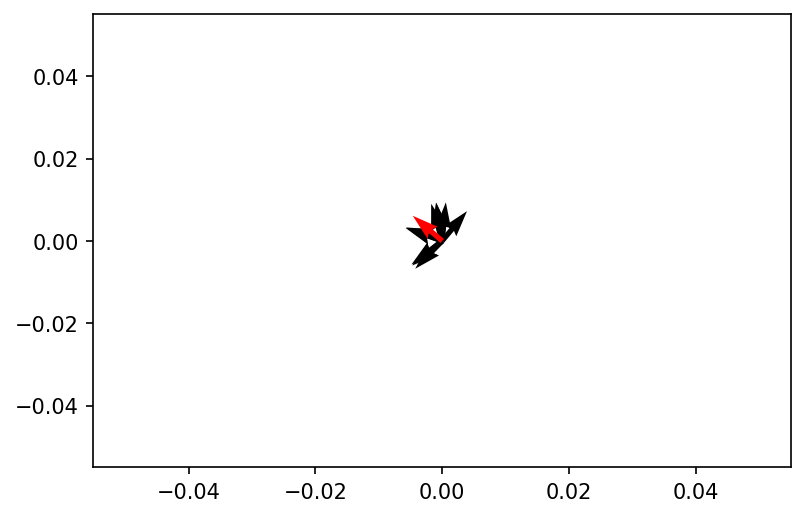

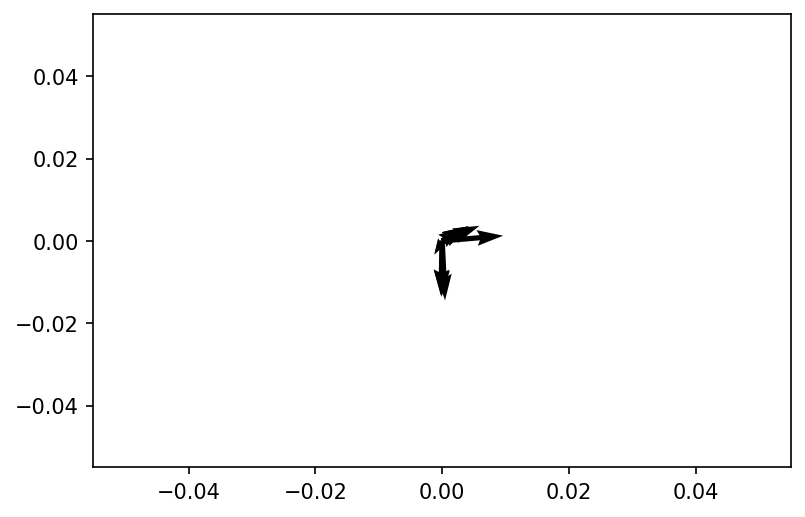

In [7]:
import matplotlib as mpl
from datasets import EmbeddedDataset
from sklearn.model_selection import ParameterGrid
import numpy as np
from datasets import EmbeddedDataset
from algorithms import block_comparison
from evaluation import evaluate_segmenter
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 150
with EmbeddedDataset('wiki_segments.npz') as ds:
    seg,emb = ds.get_file('data/6540154')
emb.shape
origin = np.zeros((2,len(emb)+1))
a = emb[:,0:2]
print(a.shape)

a /= np.sqrt(np.einsum('...i,...i', a,a))[:,np.newaxis]
s = np.sum(a,0)
s /= np.sqrt(s.dot(s.T))
print(a)
plt.quiver(*np.zeros((2,len(a))),a[:,0],a[:,1])
plt.quiver(0,0,*s,color='red')
plt.figure()
coss = np.arccos(np.array([(i.dot(s.T))/np.sqrt(i.dot(i)*s.dot(s)) for i in a]))
print(coss)
print((coss>1).sum())
print(seg)
a = a-s
v = emb[:,0:2]
sc = np.array([v[i].dot(v[i+1]) for i in range(len(v)-1)])
print(sc)
plt.quiver(*np.zeros((2,len(a))),a[:,0],a[:,1])
def angle_deviations(a):
    s = np.sum(a,0)
    s /= np.sqrt(s.dot(s.T))
    return np.arccos(np.array([(i.dot(s.T))/np.sqrt(i.dot(i)*s.dot(s)) for i in a]))
angle_deviations(v)

In [12]:
from algorithms import segments
with EmbeddedDataset('wiki_segments.npz') as ds:
    diff = 0.0
    i = 0
    for seg in ds.get_segments():
        i += 1
        emb = ds.embbeding(seg)
        print(f'{segments.count(ds[seg])} - {(angle_deviations(ds[emb]) > 1.3).sum()}')
        d = abs( segments.count(ds[seg])- (angle_deviations(ds[emb]) > 1).sum())
        print(d)
        diff += d

    print(diff/i)



7 - 8
25
6 - 3
26
3 - 2
14
4 - 0
20
3 - 1
11
4 - 7
47
4 - 0
9
5 - 4
25
3 - 0
2
7 - 11
69
10 - 5
24
6 - 5
44
8 - 4
20
59 - 84
310
6 - 11
32
4 - 0
6
19 - 24
70
9 - 6
11
6 - 7
80
6 - 19
60
4 - 2
15
22 - 36
165
3 - 2
10
3 - 0
7
37 - 57
186
11 - 25
86
6 - 12
33
3 - 1
10
3 - 1
2
6 - 7
49
4 - 2
6
4 - 4
22
8 - 12
36
6 - 10
25
3 - 0
26
8 - 7
51
6 - 2
12
4 - 0
6
5 - 3
8
4 - 2
12
3 - 0
3
3 - 0
3
3 - 1
5
3 - 1
14
13 - 21
83
4 - 4
18
7 - 3
32
5 - 16
50
4 - 1
9
10 - 11
50
38.78


In [31]:
from nltk.tokenize.texttiling import TextTilingTokenizer
import nltk
from datasets import wikiset
from evaluation import evaluate_document
import algorithms

nltk.download('stopwords')
lines = wikiset.get_unsegmented_lines(wikiset.get(),'data/988580')
text= '\n'.join(lines)
#print(text)
ttt = TextTilingTokenizer(demo_mode=True)
s, ss, d, ttSegmentation = ttt.tokenize(text)
with EmbeddedDataset('wiki_segments.npz') as ds:
   seg, emb = ds.get_file('data/988580')

simpleSegmentation = algorithms.simple_seg(emb)
sgsSegmentation = sbert_graphseg(emb)
print(len(lines))
print(segments.array_to_nltk(np.array(ttSegmentation)))
print(segments.array_to_nltk(segments.tags_to_array(seg)))
print(len(sgsSegmentation))
#evaluate_document(seg,ttSegmentation)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Radek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


f:\progs\python\magister\data\wiki_727K.tar.bz2 found: True
f:\progs\python\magister\data\wiki_test_50.tar.bz2 found: True
['data/111174', 'data/2640796', 'data/2917712', 'data/10037144', 'data/2952485', 'data/3275069', 'data/6146176', 'data/6544206', 'data/1928841', 'data/12720971', 'data/28187', 'data/7445232', 'data/109461', 'data/7674758', 'data/1198312', 'data/3384438', 'data/2025011', 'data/988580', 'data/149766', 'data/599217', 'data/3881783', 'data/2842974', 'data/31444', 'data/1057453', 'data/1276536', 'data/338825', 'data/9652769', 'data/582816', 'data/961796', 'data/1064845', 'data/380143', 'data/5160544', 'data/7150404', 'data/9387798', 'data/2651177', 'data/7370490', 'data/44426', 'data/6261767', 'data/426889', 'data/6540154', 'data/10648433', 'data/123319', 'data/4074782', 'data/32431', 'data/910628', 'data/8718322', 'data/751683', 'data/2070518', 'data/4823815', 'data/3475652']
149
000001000100010000100010001000010000001000100010000010000000001000000010001000000001000100